# Modelling

## 1. Import packeges

In [1]:
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import plotly.graph_objects as go
import plotly_calplot

In [2]:
data_input_path = '/Users/szejozsef00/Desktop/MSC/MSC 2. félév/DS Lab I/project/data/processed/'

## 2. Load the data

In [3]:
df = pd.read_csv(data_input_path + 'standardized_data.csv',sep=';',decimal=',')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df = df.fillna(0)

## 3. Transform the data

In [4]:
# Add Date column
df['DATE'] = pd.to_datetime(df['DATETIME']).dt.date

In [7]:
min_date_1  = datetime.date(2010,1,1)
max_date_1  = datetime.date(2010,3,1)

In [8]:
all_df = df.copy(deep=True)

In [9]:
df = all_df[(all_df['DATE'] >= min_date_1) & (all_df['DATE'] < max_date_1)]

In [10]:
# Melt the dataframe to DATE-DATETIME-LOCATION-VALUE format
melted_fact_df = pd.melt(df, id_vars=['DATE','DATETIME'],var_name='LOCATION', value_name='VALUE')
melted_fact_df['LOCATION'] = melted_fact_df['LOCATION'].astype(int)
lmelted_fact_df = melted_fact_df.sort_values('LOCATION')
melted_fact_df.head(5)

,DATE,DATETIME,LOCATION,VALUE
0,2010-01-01,2010-01-01 00:00:00,0,-0.499968
1,2010-01-01,2010-01-01 00:05:00,0,-0.512966
2,2010-01-01,2010-01-01 00:10:00,0,-0.525964
3,2010-01-01,2010-01-01 00:15:00,0,-0.538963
4,2010-01-01,2010-01-01 00:20:00,0,-0.551961


In [11]:
# Groupby the dataframe to DATE-LOCATION-VALUE_LIST format
daily_fact_df = melted_fact_df.groupby(['DATE','LOCATION'])['VALUE'].apply(np.array).reset_index(name='VALUE_LIST')
daily_fact_df.head(5)

,DATE,LOCATION,VALUE_LIST
0,2010-01-01,0,"[-0.49996763, -0.512966, -0.52596426, -0.53896..."
1,2010-01-01,1,"[0.72272563, 0.72272563, 0.72272563, 0.7227256..."
2,2010-01-01,2,"[-0.877841, -0.8722783, -0.86671567, -0.861152..."
3,2010-01-01,3,"[-0.8680591, -0.8832556, -0.8984521, -0.913648..."
4,2010-01-01,4,"[-0.5024111, -0.5139335, -0.5254558, -0.536978..."


In [12]:
# Melt the dataframe to LOCATION-VALUE_LIST format
location_fact_df = daily_fact_df.groupby(['LOCATION'])['VALUE_LIST'].apply(np.array).reset_index(name='VALUE_LIST')
# stack the data to (450,288) shape
location_fact_df['VALUE_LIST'] = location_fact_df['VALUE_LIST'].apply(lambda x : np.stack(x,axis = 0))
# reshape the data to (450,288,1) shape
location_fact_df['VALUE_LIST'] = location_fact_df['VALUE_LIST'].apply(lambda x : x.reshape(59,288,1))
location_fact_df.head(5)

,LOCATION,VALUE_LIST
0,0,"[[[-0.49996763], [-0.512966], [-0.52596426], [..."
1,1,"[[[0.72272563], [0.72272563], [0.72272563], [0..."
2,2,"[[[-0.877841], [-0.8722783], [-0.86671567], [-..."
3,3,"[[[-0.8680591], [-0.8832556], [-0.8984521], [-..."
4,4,"[[[-0.5024111], [-0.5139335], [-0.5254558], [-..."


## 4. Modelling

In [13]:
min_date  = melted_fact_df['DATE'].min()
max_date  = melted_fact_df['DATE'].max()
date_interval = pd.date_range(min_date,max_date, freq='D')

# control_datetimes = pd.date_range(
#     start = melted_fact_df['DATETIME'].min(),
#     end = melted_fact_df['DATETIME'].max(),
#     freq = "5T"
# )

In [14]:
location_fact_df[location_fact_df['LOCATION'] == 0]['VALUE_LIST'].values[0].shape

(59, 288, 1)

In [15]:
cluster_number = 4
location_number = 20

2
3
4
5


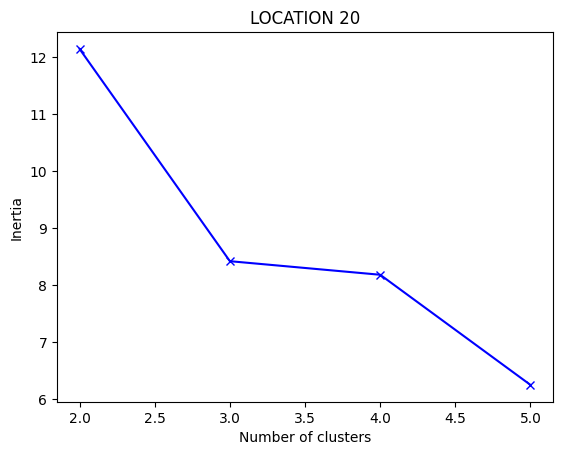

2
3
4
5


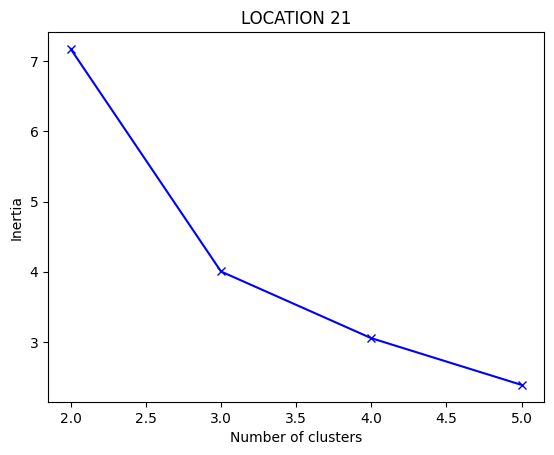

2
3
4
5


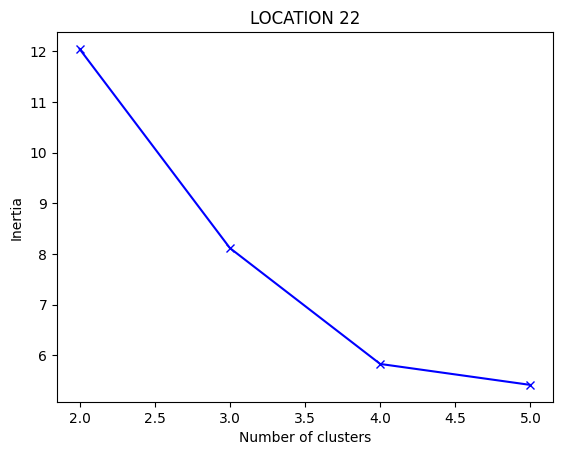

2
3
4
5


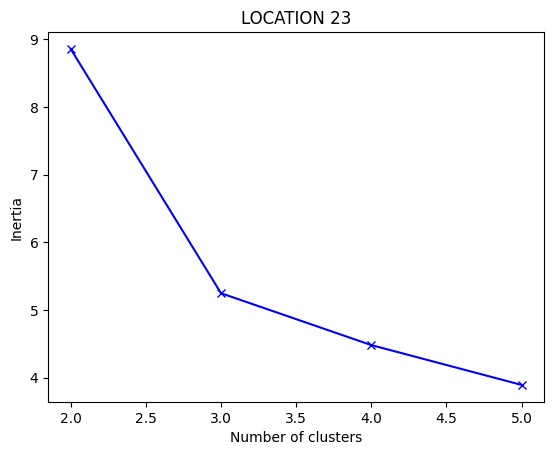

In [19]:
potential_cluster_numbers = range(2,6)

for loc in range(20,24):
    Sum_of_squared_distances = []
    for k in potential_cluster_numbers:
        print(k)
        km = TimeSeriesKMeans(n_clusters=k,
                            n_init=2,
                            metric="dtw",
                            verbose=False,
                            # max_iter_barycenter=3,
                            # random_state = 42
                            )
        
        km = km.fit(location_fact_df[location_fact_df['LOCATION'] == loc]['VALUE_LIST'].values[0])
        Sum_of_squared_distances.append(km.inertia_)
        
    plt.plot(potential_cluster_numbers, Sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title(f'LOCATION {loc}')  
    plt.show()

In [17]:
# DTW-k-means
cluster_centers = pd.DataFrame()
location_clusters = pd.DataFrame()


for loc in range(0,location_number):
    print(f"LOCATION {loc}, DTW k-means")
    dtw_km = TimeSeriesKMeans(n_clusters=cluster_number,
                            max_iter = 3,
                            metric="dtw",
                            # metric_params={"gamma": .01},
                            verbose=False,
                            random_state=42)
    curr_input = location_fact_df[location_fact_df['LOCATION'] == loc]['VALUE_LIST'].values[0]
    curr_y_pred = dtw_km.fit_predict(curr_input)
    print("Best:", dtw_km.inertia_)

    curr_location_clusters = pd.DataFrame(curr_y_pred,columns=['CLUSTERS'])
    curr_location_clusters.insert(0,"LOCATION",loc)
    curr_location_clusters.insert(0,"DATE",date_interval)

    location_clusters = pd.concat([location_clusters,curr_location_clusters])


    curr_cluster_centers = pd.DataFrame({'CLUSTERS' : range(0,cluster_number), 'CLUSTER_CENTERS': dtw_km.cluster_centers_.reshape(cluster_number,288).tolist()})
    curr_cluster_centers.insert(0,"LOCATION",loc)

    cluster_centers = pd.concat([cluster_centers,curr_cluster_centers])


LOCATION 0, DTW k-means
Best: 11.879795045390043
LOCATION 1, DTW k-means
Best: 7.432768630726182
LOCATION 2, DTW k-means
Best: 5.662941125488218
LOCATION 3, DTW k-means
Best: 6.204538855215094
LOCATION 4, DTW k-means
Best: 6.932844664086544
LOCATION 5, DTW k-means
Best: 4.38220744114022
LOCATION 6, DTW k-means
Best: 4.596407063664758
LOCATION 7, DTW k-means
Best: 2.8251575541965326
LOCATION 8, DTW k-means
Best: 3.396980700573157
LOCATION 9, DTW k-means
Best: 4.856792834831713
LOCATION 10, DTW k-means
Best: 3.171276655086808
LOCATION 11, DTW k-means
Best: 2.154892018733286
LOCATION 12, DTW k-means
Best: 3.8969913244526118
LOCATION 13, DTW k-means
Best: 6.061941399800034
LOCATION 14, DTW k-means
Best: 5.354583930575531
LOCATION 15, DTW k-means
Best: 4.7224642908866805
LOCATION 16, DTW k-means
Best: 0.10234969063486274
LOCATION 17, DTW k-means
Best: 1.2177616484953069
LOCATION 18, DTW k-means
Best: 0.015585539633835403
LOCATION 19, DTW k-means
Best: 0.28218788437609843


In [18]:
location_clusters.columns = ['DATE','LOCATION','CLUSTERS']

In [19]:
location_clusters['CLUSTERS'] = location_clusters['CLUSTERS'].apply(lambda x : x + 1)
location_clusters.head()

,DATE,LOCATION,CLUSTERS
0,2010-01-01,0,2
1,2010-01-02,0,3
2,2010-01-03,0,2
3,2010-01-04,0,2
4,2010-01-05,0,4


In [20]:
#change date type
location_clusters['DATE'] = pd.to_datetime(location_clusters['DATE'])
#Set index as interact_day
# location_clusters.set_index('DATE', inplace = True)

In [22]:
for loc in range(0,location_number):
    # generate the plot
    curr = location_clusters[location_clusters['LOCATION'] == loc].copy(deep=True)
    fig = plotly_calplot.calplot(
        curr,
        x="DATE",
        y="CLUSTERS",
        years_title=True,
        showscale=True,
        colorscale='viridis',
        title=f"LOCATION {loc} clustering result",
        start_month=1,
        end_month=2
    )


    fig.update_layout({
        'height': 300,
        'width' : 900,
        'margin': {'b': 20, 't': 60},
    })

    fig.show()


    # ax = calplot.calplot(
    #     data = curr['CLUSTERS'],
    #     how = None,
    #     cmap = 'Dark2',
    #     figsize = (16, 8),
    #     suptitle = "Title"
    # )


In [24]:
daily_fact_df['DATE'] = pd.to_datetime(daily_fact_df['DATE'])
location_clusters['DATE'] = pd.to_datetime(location_clusters['DATE'])
clustered_daily_fact_df = daily_fact_df.merge(location_clusters,on=['DATE','LOCATION'],how='left')
clustered_daily_fact_df

,DATE,LOCATION,VALUE_LIST,CLUSTERS
0,2010-01-01,0,"[-0.49996763, -0.512966, -0.52596426, -0.53896...",2.0
1,2010-01-01,1,"[0.72272563, 0.72272563, 0.72272563, 0.7227256...",1.0
2,2010-01-01,2,"[-0.877841, -0.8722783, -0.86671567, -0.861152...",2.0
3,2010-01-01,3,"[-0.8680591, -0.8832556, -0.8984521, -0.913648...",2.0
4,2010-01-01,4,"[-0.5024111, -0.5139335, -0.5254558, -0.536978...",4.0
...,...,...,...,...
113039,2010-02-28,1911,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
113040,2010-02-28,1912,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
113041,2010-02-28,1913,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
113042,2010-02-28,1914,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN


In [25]:
def plot_result(clustered_daily_fact_df, location_nr, time_range, color_palette):
    loc0_clustered_daily_fact_df = clustered_daily_fact_df[clustered_daily_fact_df['LOCATION'] == location_nr]

    fig = go.Figure()

    for i, row in loc0_clustered_daily_fact_df.iterrows():
        cluster_number = int(row["CLUSTERS"])

        fig.add_trace(
            go.Scatter(
                x=time_range,
                y=row["VALUE_LIST"],
                mode="lines",
                name=f"C{int(row['CLUSTERS'])} {row['DATE'].date()}",
                line=dict(width=2, color = color_palette[cluster_number]),
            )
        )

    fig.update_layout(
        title=f"Location {location_nr} daily clusters",
        xaxis_title="TIme",
        yaxis_title="Value",
        # legend=dict(title="Clusters"),
        # plot_bgcolor="white",
        # xaxis=dict(showgrid=True),
        # yaxis=dict(showgrid=True),
    )

    fig.show()

    display(loc0_clustered_daily_fact_df['CLUSTERS'].value_counts())


In [29]:
time_range = pd.date_range(start="00:00", end="23:55", freq="5T")
color_palette = ['black', "purple", "blue", "green", "yellow"]

plot_result(clustered_daily_fact_df, 7, time_range, color_palette)

CLUSTERS
2.0    38
1.0    17
3.0     3
4.0     1
Name: count, dtype: int64